# Fitting max-stable PCA to max-linear models

In [1]:
library(evd)
library(maxstablePCA)
library(dplyr)
library(GGally)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### setup parameters and simulate data 

In [2]:
set.seed(7142128)
#set.seed(51015)
s <- 100

In [3]:
A1 <- matrix(
    c(
        6/10, 1 / 20, 1/10, 6 / 17, 6 / 18, 
        3 / 10, 15 / 20, 1 / 10, 3 / 17, 4 / 18, 
        1 / 10, 4 / 20, 8 / 10, 8 / 17, 8 / 18
     ), 
    5, 3
)

In [4]:
A1

0.6000000,0.3000000,0.1000000
0.0500000,0.7500000,0.2000000
0.1000000,0.1000000,0.8000000
0.3529412,0.1764706,0.4705882
0.3333333,0.2222222,0.4444444


In [5]:
Z1 <- matrix(rfrechet(30000), 10000, 3)
X1 <- t(maxmatmul(A1, t(Z1)))

In [6]:
X1trafo <- transform_unitpareto(X1)

In [7]:
summary(apply(X1trafo, 1, max))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    1.017     2.121     3.658    19.743     8.014 10000.000 

In [8]:
length(which(apply(X1trafo, 1, max) > s))

[1] 216

# Perform max-stable PCA for perfectly reconstrucable simulated data

In [9]:
maxPCAX1P1 <- max_stable_prcomp(X1trafo, p=1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P2 <- max_stable_prcomp(X1trafo, p=2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P3 <- max_stable_prcomp(X1trafo, p=3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX1P4 <- max_stable_prcomp(X1trafo, p=4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [10]:
maxPCAX1P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
           [,1]       [,2]       [,3]
[1,] 1.34804255 0.30923580 0.04523401
[2,] 0.01767006 1.35651271 0.19396480
[3,] 0.04599736 0.07576909 1.46619183
[4,] 0.82679119 0.24147409 0.83212642
[5,] 0.78241050 0.41579434 0.78066715

$encoder_matrix
           [,1]       [,2]       [,3]        [,4]       [,5]
[1,] 0.74182039 0.19600779 0.07199331 0.091336178 0.08527584
[2,] 0.04600253 0.73719135 0.08504490 0.069297067 0.01755644
[3,] 0.04780269 0.06871423 0.68205411 0.002992819 0.14805921

$reconstr_matrix
           [,1]      [,2]       [,3]        [,4]       [,5]
[1,] 1.00000546 0.2642268 0.09705004 0.123125055 0.11495547
[2,] 0.06240302 1.0000094 0.13229449 0.094002352 0.02871828
[3,] 0.07008792 0.1007482 1.00002217 0.005250576 0.21708321
[4,] 0.61333057 0.1780126 0.56755525 0.075515948 0.12320398
[5,] 0.58040806 0.3065200 0.53245724 0.071462385 0.11558496

$loss_fctn_value
[1] 0.1083508

$optim_conv_status
[1] 4

$s
[1] 100

$starting_vals
$starting_v

In [11]:
round(maxPCAX1P3$decoder_matrix, 2)

1.35,0.31,0.05
0.02,1.36,0.19
0.05,0.08,1.47
0.83,0.24,0.83
0.78,0.42,0.78


In [12]:
round(maxPCAX1P3$encoder_matrix, 2)

0.74,0.20,0.07,0.09,0.09
0.05,0.74,0.09,0.07,0.02
0.05,0.07,0.68,0.00,0.15


### elbow plot and pairplot to visually inspect fit 

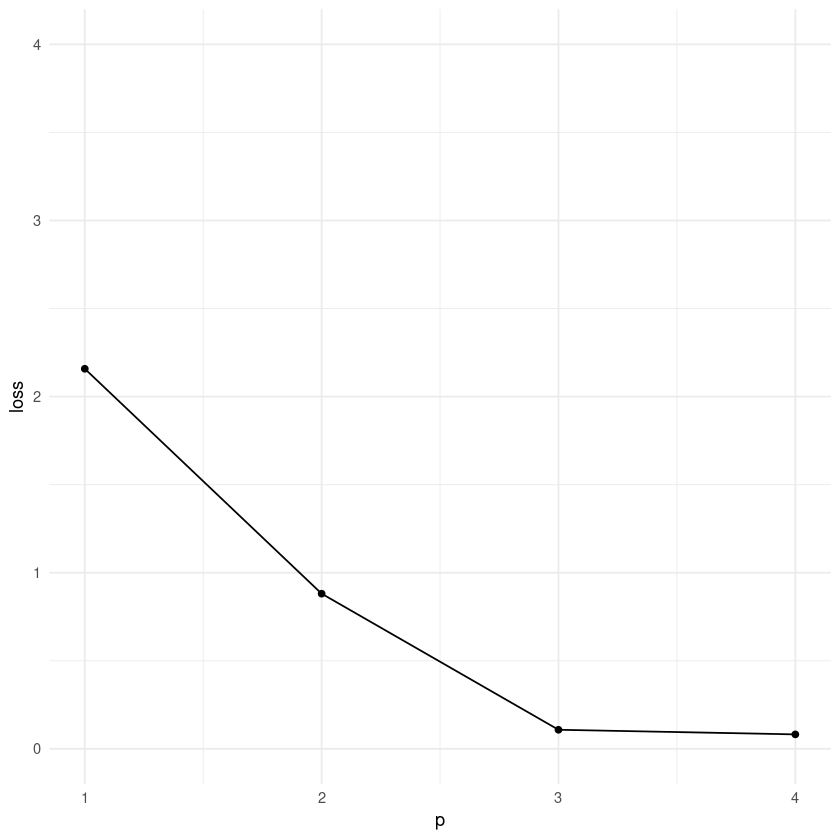

In [13]:
plotlossdatX1 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX1P1$loss_fctn_value,
        maxPCAX1P2$loss_fctn_value,
        maxPCAX1P3$loss_fctn_value,
        maxPCAX1P4$loss_fctn_value
    )
)

pe1 <- ggplot(aes(x = p, y = loss), data = plotlossdatX1) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe1

In [14]:
ggsave("mlm_lindep_elbow.pdf", pe1)

Saving 6.67 x 6.67 in image


In [15]:
rec1 <- t(maxmatmul(maxPCAX1P3$reconstr_matrix, t(X1)))

datX1 <- data.frame(X1)
datX1$is_rec = "original"
datrec1 <- data.frame(rec1)
datrec1$is_rec = "reconstruction"
names(datrec1) <- names(datX1)
plot_datX1 <- full_join(datX1, datrec1)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


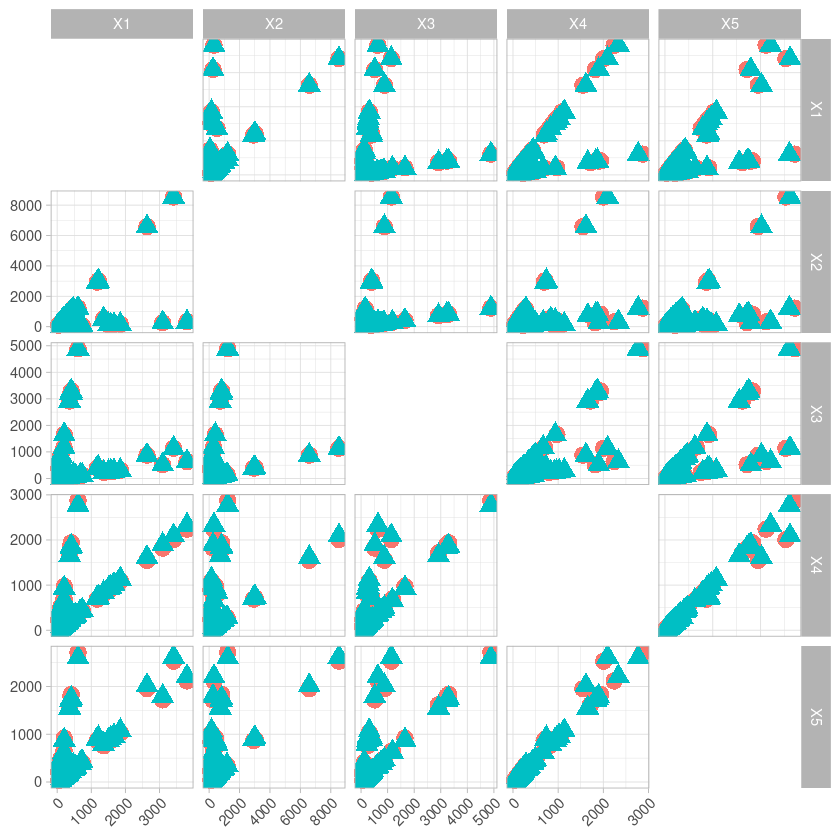

In [16]:
p1 <- ggpairs(
    plot_datX1, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = 1:5,
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
p1

In [17]:
ggsave("mlm_lindep.png", p1)

Saving 6.67 x 6.67 in image


# not perfectly reconstructable second model

In [18]:
A2 <- matrix(
    c(
        2/3, 2/3, 0, 0, 1 / 5, 
        0, 1/3, 2/3, 1/3, 3 / 5, 
        1 / 3, 0, 1/3, 2/3, 1 / 5
     ), 
    5, 3
)

In [19]:
A2

0.6666667,0.0000000,0.3333333
0.6666667,0.3333333,0.0000000
0.0000000,0.6666667,0.3333333
0.0000000,0.3333333,0.6666667
0.2000000,0.6000000,0.2000000


In [20]:
Z2 <- matrix(rfrechet(30000), 10000, 3)
X2 <- t(maxmatmul(A2, t(Z2)))
X2trafo <- transform_unitpareto(X2)

In [21]:
length(which(apply(X2trafo, 1, max) > s))

[1] 195

In [22]:
maxPCAX2P1 <- max_stable_prcomp(X2trafo, p=1, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P2 <- max_stable_prcomp(X2trafo, p=2, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P3 <- max_stable_prcomp(X2trafo, p=3, s = s, n_initial_guesses = 15000, norm = "linfty")
maxPCAX2P4 <- max_stable_prcomp(X2trafo, p=4, s = s, n_initial_guesses = 15000, norm = "linfty")

In [23]:
maxPCAX2P3

$p
[1] 3

$d
[1] 5

$decoder_matrix
            [,1]         [,2]         [,3]
[1,] 0.682371509 0.7856499745 0.0006934797
[2,] 0.001405535 1.1376249606 0.0017708992
[3,] 0.304802206 0.1068913700 1.1489626010
[4,] 1.261355289 0.0004540134 0.0033538690
[5,] 0.444003780 0.1766640546 1.0685341913

$encoder_matrix
             [,1]         [,2]         [,3]         [,4]        [,5]
[1,] 0.0005733894 1.580042e-05 0.0640500715 0.7928098575 0.002248232
[2,] 0.0008575232 8.790204e-01 0.0002315618 0.0006531885 0.001088386
[3,] 0.0298824810 3.148894e-02 0.1574021791 0.4049543888 0.935859170

$reconstr_matrix
             [,1]        [,2]         [,3]        [,4]        [,5]
[1,] 0.0006737131 0.690602352 0.0437059439 0.540990859 0.001534130
[2,] 0.0009755398 0.999995544 0.0002787434 0.001114322 0.001657312
[3,] 0.0343338531 0.093959694 0.1808492171 0.465277448 1.075267186
[4,] 0.0007232477 0.000399087 0.0807898965 1.000014907 0.003138749
[5,] 0.0319304527 0.155291307 0.1681896102 0.432707610 0.999

In [24]:
round(maxPCAX2P3$decoder_matrix, 2)

0.68,0.79,0.00
0.00,1.14,0.00
0.30,0.11,1.15
1.26,0.00,0.00
0.44,0.18,1.07


In [25]:
round(maxPCAX2P3$encoder_matrix, 2)

0.00,0.00,0.06,0.79,0.00
0.00,0.88,0.00,0.00,0.00
0.03,0.03,0.16,0.40,0.94


In [26]:
round(maxPCAX2P3$reconstr_matrix, 2)

0.00,0.69,0.04,0.54,0.00
0.00,1.00,0.00,0.00,0.00
0.03,0.09,0.18,0.47,1.08
0.00,0.00,0.08,1.00,0.00
0.03,0.16,0.17,0.43,1.00


### elbow plot and pairplot to visually inspect fit

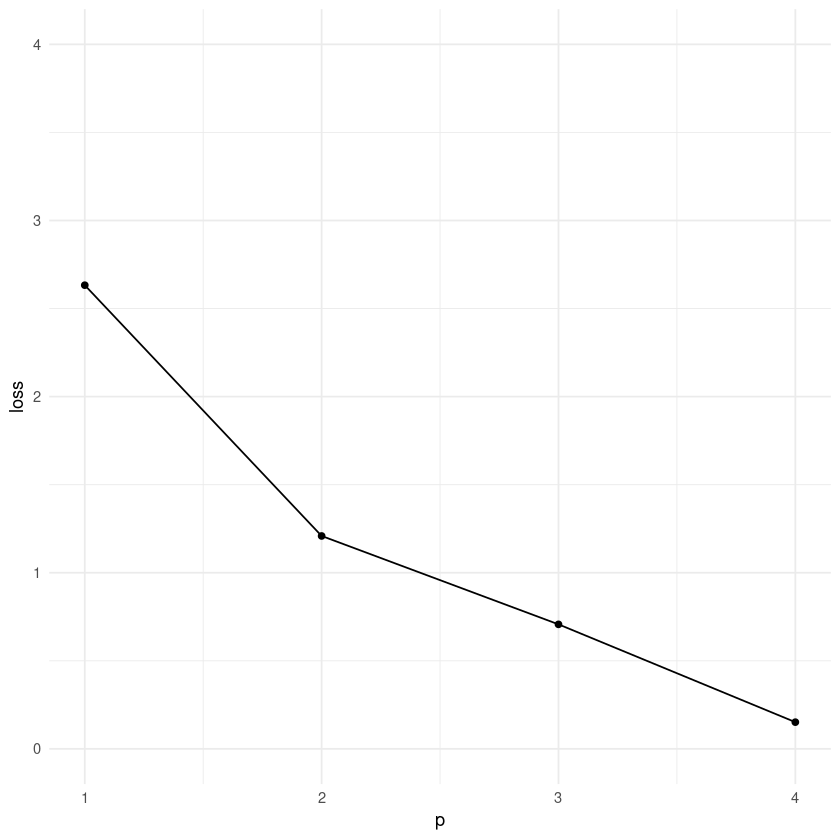

In [27]:
plotlossdatX2 <- data.frame(
    p = 1:4, 
    loss = c(
        maxPCAX2P1$loss_fctn_value,
        maxPCAX2P2$loss_fctn_value,
        maxPCAX2P3$loss_fctn_value,
        maxPCAX2P4$loss_fctn_value
    )
)

pe2 <- ggplot(aes(x = p, y = loss), data = plotlossdatX2) + geom_line() + geom_point() + ylim(0,4) + theme_minimal()
pe2

In [28]:
ggsave("mlm_nolindep_elbow.pdf", pe2)

Saving 6.67 x 6.67 in image


In [29]:
rec2 <- t(maxmatmul(maxPCAX2P3$reconstr_matrix, t(X2)))

datX2 <- data.frame(X2)
datX2$is_rec = "original"
datrec2 <- data.frame(rec2)
datrec2$is_rec = "reconstruction"
names(datrec2) <- names(datX2)
plot_datX2 <- full_join(datX2, datrec2)

Joining with `by = join_by(X1, X2, X3, X4, X5, is_rec)`


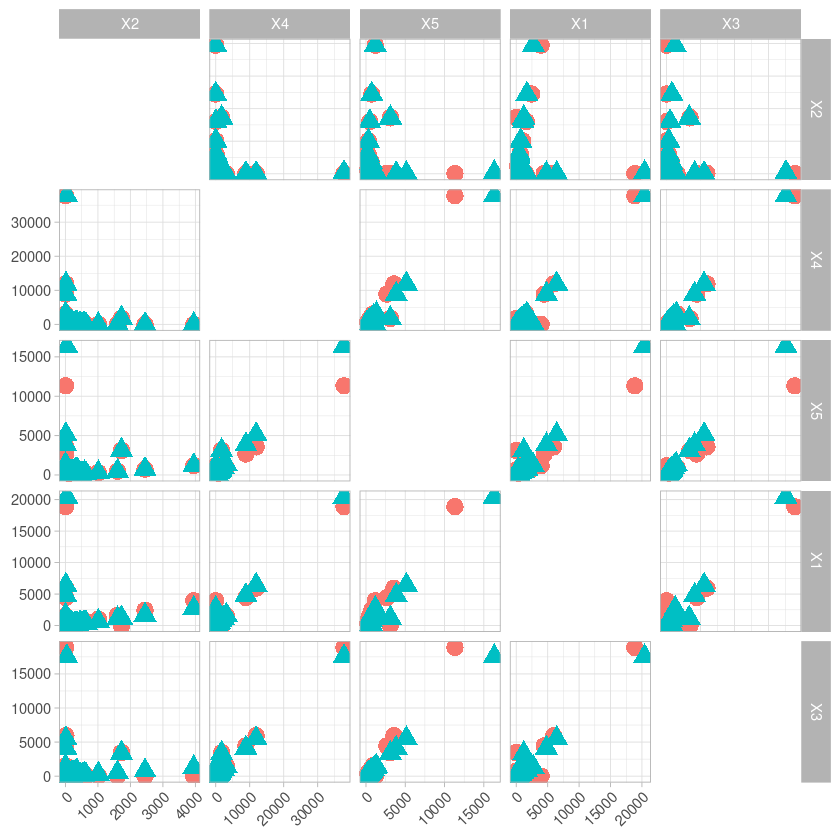

In [30]:
p2 <- ggpairs(
    plot_datX2, 
    aes(color = is_rec, shape = is_rec, size = 2),
    columns = c(2,4,5,1,3),
    upper = list(continuous = "points", combo = "dot_no_facet"),
    diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

p2

In [31]:
ggsave("mlm_nolindep.png", p2)

Saving 6.67 x 6.67 in image


# Comparison to other dimension reduction techniques

### Sabourin Drees PCA for multivariate extremes

In [32]:
Xsphere1 <- t(apply(X1, 1, function(z) z / sum(z)))
Xsphere1 <- Xsphere1[which(rowSums(X1) > 250), ]
                    
Xsphere2 <- t(apply(X2, 1, function(z) z / sum(z)))
Xsphere2 <- Xsphere2[which(rowSums(X2) > 250), ]              

In [33]:
specdecomp1 <- eigen(t(Xsphere1) %*% Xsphere1 / 40)
specdecomp1

eigen() decomposition
$values
[1] 9.500974e-01 2.436175e-01 1.804322e-01 6.646972e-05 2.348671e-06

$vectors
           [,1]       [,2]       [,3]         [,4]        [,5]
[1,] -0.4447890  0.3329493  0.6737775 -0.486825011  0.01824170
[2,] -0.4391304  0.6541949 -0.6131812 -0.002146806 -0.05654760
[3,] -0.4550909 -0.6371384 -0.3548792 -0.509970480  0.03062215
[4,] -0.4490174 -0.1987385  0.1725229  0.486813956 -0.70152294
[5,] -0.4478871 -0.1254247  0.1197048  0.515692817  0.70950508


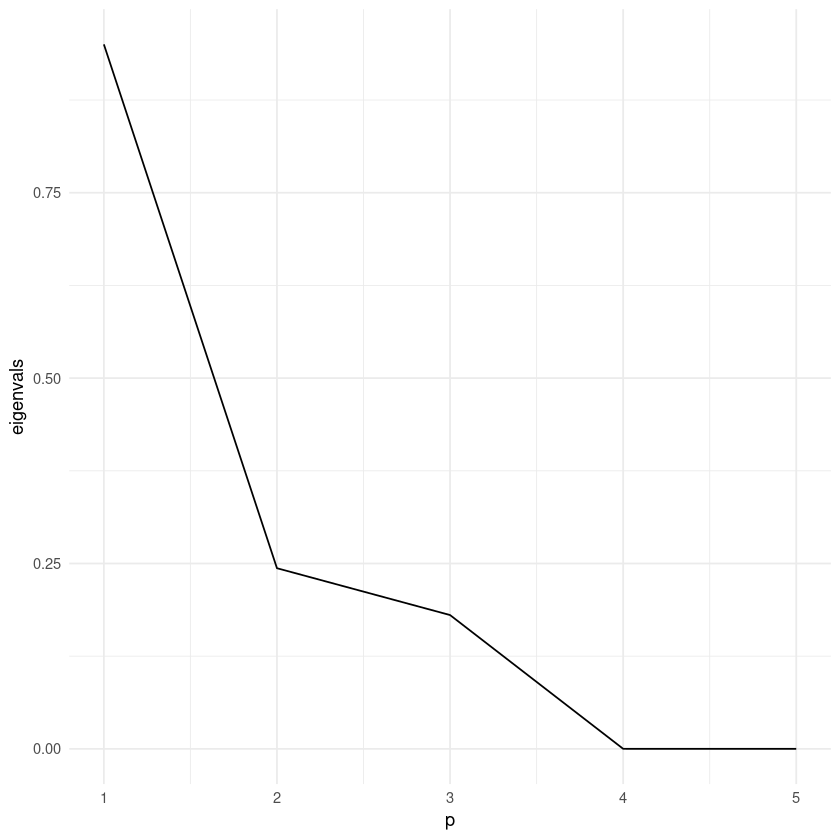

In [34]:
screeplotdat <- data.frame(p = 1:5, eigenvals = specdecomp1$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat) + 
geom_line() + 
theme_minimal()

In [35]:
rec1 <- X1 %*% specdecomp1$vectors[1:5, 1:3] %*% t(specdecomp1$vectors[1:5, 1:3])

plotdat_DS1 <- data.frame(X1)
tmp <- data.frame(rec1)
plotdat_DS1 <- full_join(plotdat_DS1, tmp)
plotdat_DS1$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


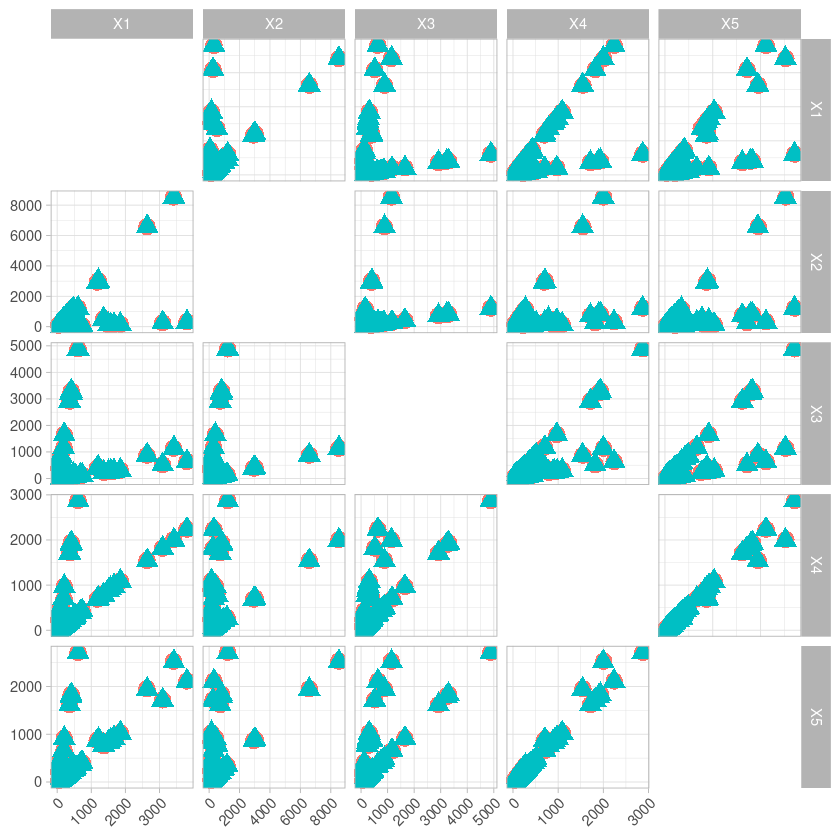

In [36]:
ggpairs(plotdat_DS1,
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

In [37]:
specdecomp2 <- eigen(t(Xsphere2) %*% Xsphere2 / 40)

In [38]:
rec2 <- X2 %*% specdecomp2$vectors[1:5, 1:3] %*% t(specdecomp2$vectors[1:5, 1:3])
 
plotdat_DS2 <- data.frame(X2)
tmp <- data.frame(rec2)
plotdat_DS2 <- full_join(plotdat_DS2, tmp)
plotdat_DS2$is_rec <- c(rep(F, 10000), rep(T, 10000))

Joining with `by = join_by(X1, X2, X3, X4, X5)`


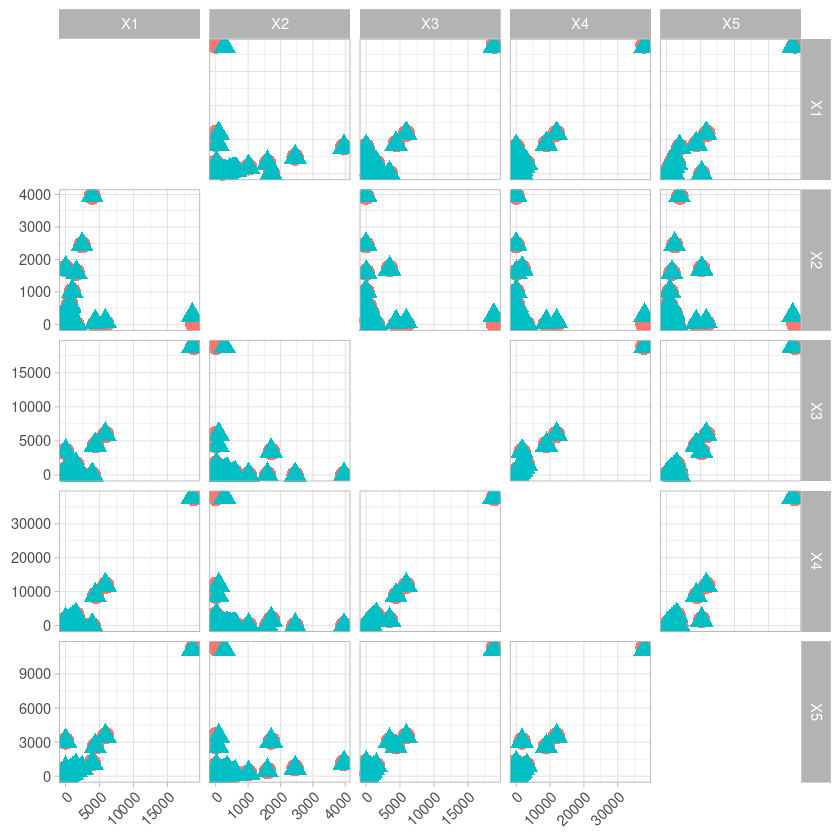

In [39]:
ggpairs(plotdat_DS2,     
        aes(color = is_rec, shape = is_rec, size = 2),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

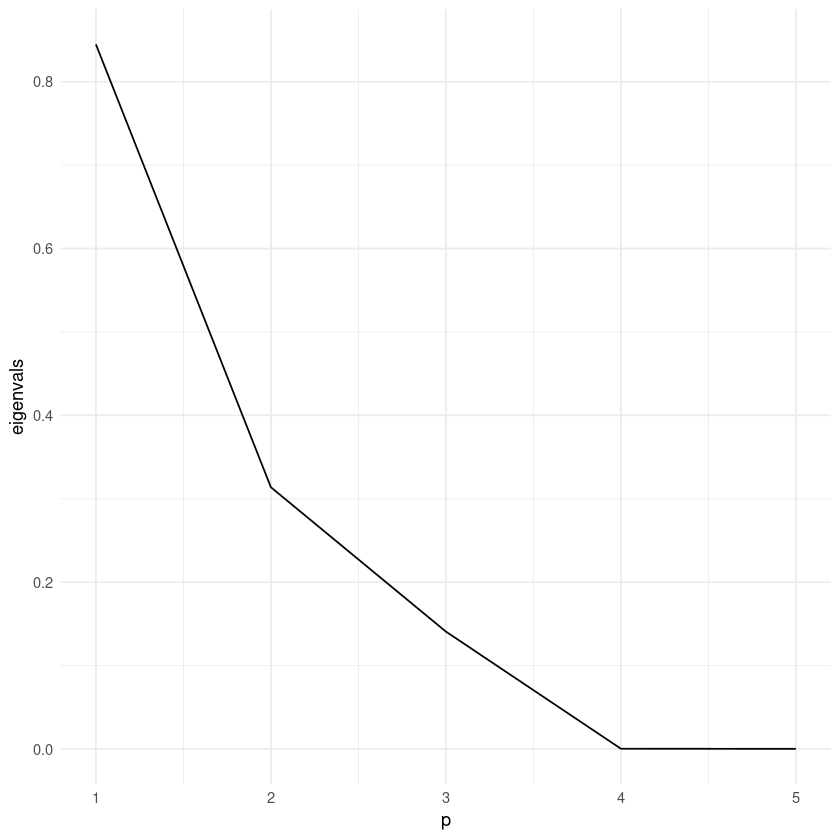

In [40]:
screeplotdat2 <- data.frame(p = 1:5, eigenvals = specdecomp2$values)

ggplot(aes(x = p, y = eigenvals), data = screeplotdat2) + 
geom_line() + 
theme_minimal()

# PCA by Cooley and Thibaud 

In [41]:
# Tail pairwise dependence matrix code by Yiang 

decls <- function(x, th, k) {
    ## Ordinary decluster.
    id.big <- which(x > th)
    id.dif <- diff(id.big)
    tick <- which(id.dif >= k)
    start <- id.big[c(1, tick + 1)]              # Where a new cluster begins
    end <- c(id.big[tick], last(id.big, 1))
    n <- length(start)
    id.res <- rep(0, n)
    for ( i in 1 : n) {
        temp <- x[start[i] : end[i]]
        id.res[i] <- which(temp == max(temp, na.rm = TRUE))[1] + start[i] - 1
    }
    id.res
}

rw.Sigma <- function(X, u = 0.98, decluster = F) {
    ## Compute TPDM
    P <- ncol(X)                      # Number of stations
    M <- nrow(X)                      # Number of obs
    Sigma <- matrix(0, P, P)
    for ( i in 1 : P) {
        if (i %% 5 == 0) print(i)
        for ( j in 1 : P) {
            r <- sqrt(X[, i] ^ 2 + X[, j] ^ 2)
            w1 <- X[, i] / r
            w2 <- X[, j] / r
            th <- quantile(r, u, na.rm = TRUE)
            if(decluster) {
                id <- decls(r, th, 5)
            } else {
                id <- which(r > th)
            } 
            Sigma[i, j] <- sum(w1[id] * w2[id], na.rm = TRUE) / (length(id)) * 2
        }
    }
    Sigma
}

ecdf_shifted <- function(z) length(z) / (length(z) + 1) * ecdf(z)(z) + 1 / (length(z) + 1)

##applies the transformation t
trans <- function(x)
{
    ##because it takes an exponential, this function flakes out if x is too big
    ##hence for big values of x, we return x
    v <- log(1 + exp(x))
    id <- which(x < -20)
    v[!is.finite(v)] <- x[!is.finite(v)]
    v[id] <- exp(x[id])
    return(v)
}

##applies the inverse transformation t^{-1}
invTrans <- function(v)
{
    ##same trickeration for big values of v
    ##still returns -Inf if v is machine zero
    x <- log(exp(v) - 1)
    x[!is.finite(x) & v > 1 & !is.na(x)] <- v[!is.finite(x) & v > 1 &
                                                  !is.na(x)]

    return(x)
}

In [42]:
# Transform data to approximately 2-Fréchet margins 
X1trafo_2frech <- apply(X1trafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))
X2trafo_2frech <- apply(X2trafo, 2, function(z) sqrt(-log(ecdf_shifted(z))))

In [43]:
tpdm1 <- rw.Sigma(X1trafo_2frech)
tpdm2 <- rw.Sigma(X2trafo_2frech)

# tpdm <- nearPD(tpdm)$mat

[1] 5
[1] 5


In [44]:
specdecomp1_cy <- eigen(tpdm1)
specdecomp2_cy <- eigen(tpdm2)

In [45]:
if(specdecomp1_cy$vectors[1,1] < 0) specdecomp1_cy$vectors[,1] <- -specdecomp1_cy$vectors[,1]
if(specdecomp2_cy$vectors[1,1] < 0) specdecomp2_cy$vectors[,1] <- -specdecomp2_cy$vectors[,1]

Saving 6.67 x 6.67 in image


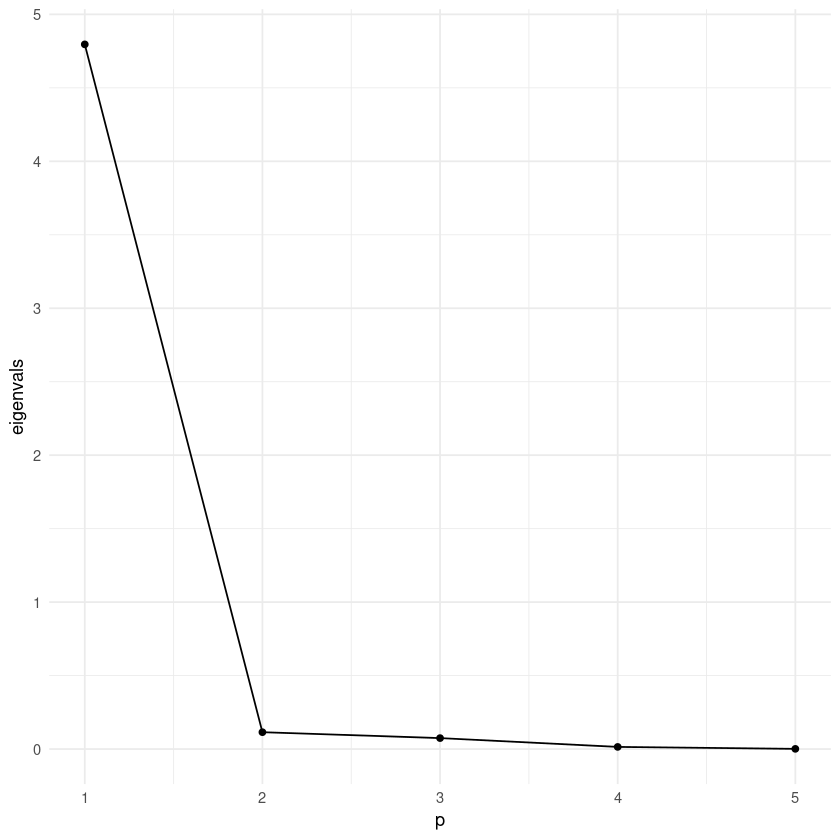

In [46]:
elbow_dat1_cy <- data.frame(p = 1:5, eigenvals = specdecomp1_cy$values)
elbow1_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat1_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_mlm1.pdf", elbow1_cy)
elbow1_cy

Saving 6.67 x 6.67 in image


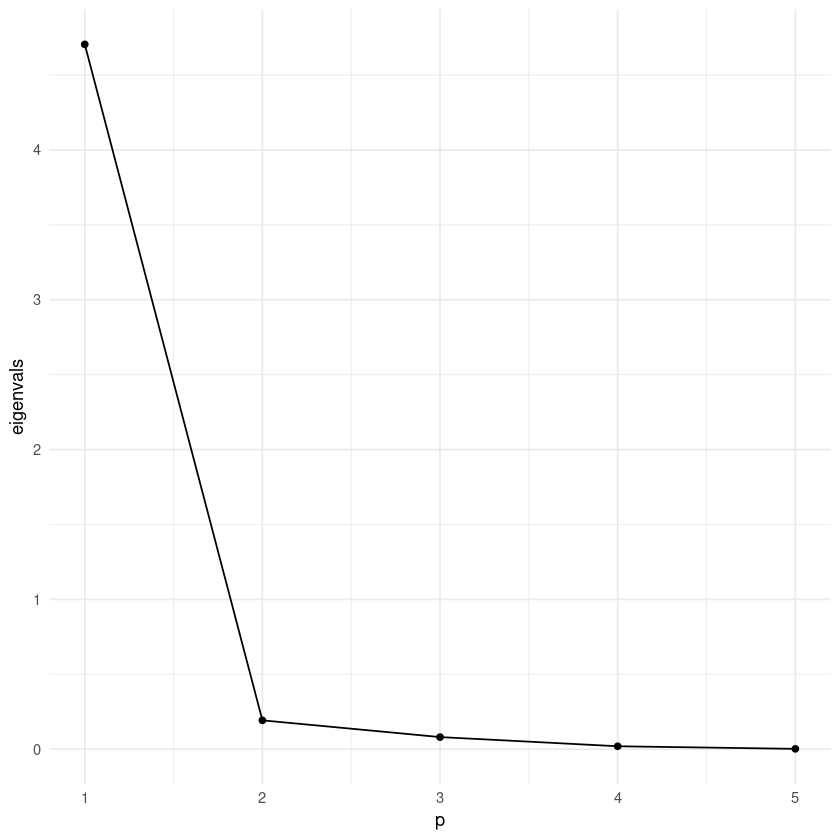

In [47]:
elbow_dat2_cy <- data.frame(p = 1:5, eigenvals = specdecomp2_cy$values)
elbow2_cy <- ggplot(aes(x = p, y = eigenvals), data = elbow_dat2_cy) +
geom_line() + 
geom_point () + 
theme_minimal()

ggsave("elbow_epca_cy_mlm2.pdf", elbow2_cy)
elbow2_cy

In [48]:
enc1_cy <- t(specdecomp1_cy$vectors[, 1:3]) %*% t(invTrans(X1trafo_2frech))
rec1_cy <- t(specdecomp1_cy$vectors[, 1:3] %*% trans(enc1_cy))

enc2_cy <- t(specdecomp2_cy$vectors[, 1:3]) %*% t(invTrans(X2trafo_2frech))
rec2_cy <- t(specdecomp2_cy$vectors[, 1:3] %*% trans(enc2_cy))

Joining with `by = join_by(X1, X2, X3, X4, X5)`
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or val

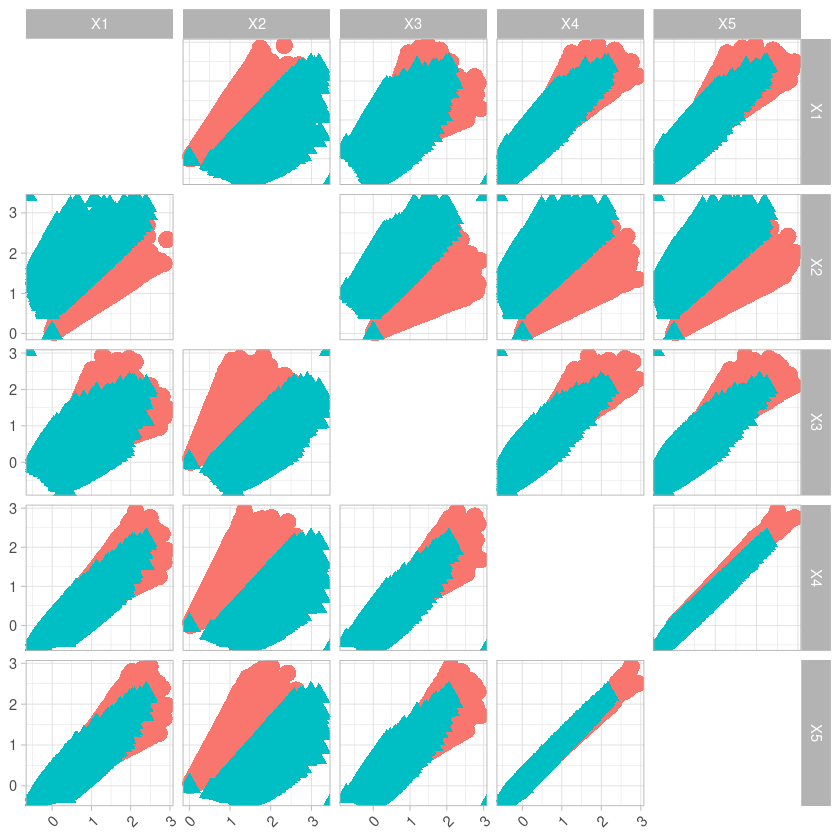

In [49]:
plot_dat1 <- data.frame(X1trafo_2frech)
tmp <- data.frame(rec1_cy)
plot_dat1 <- full_join(plot_dat1, tmp)
plot_dat1$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat1, 
        aes(color = is_rec, shape = is_rec, size = 1),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Joining with `by = join_by(X1, X2, X3, X4, X5)`
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or val

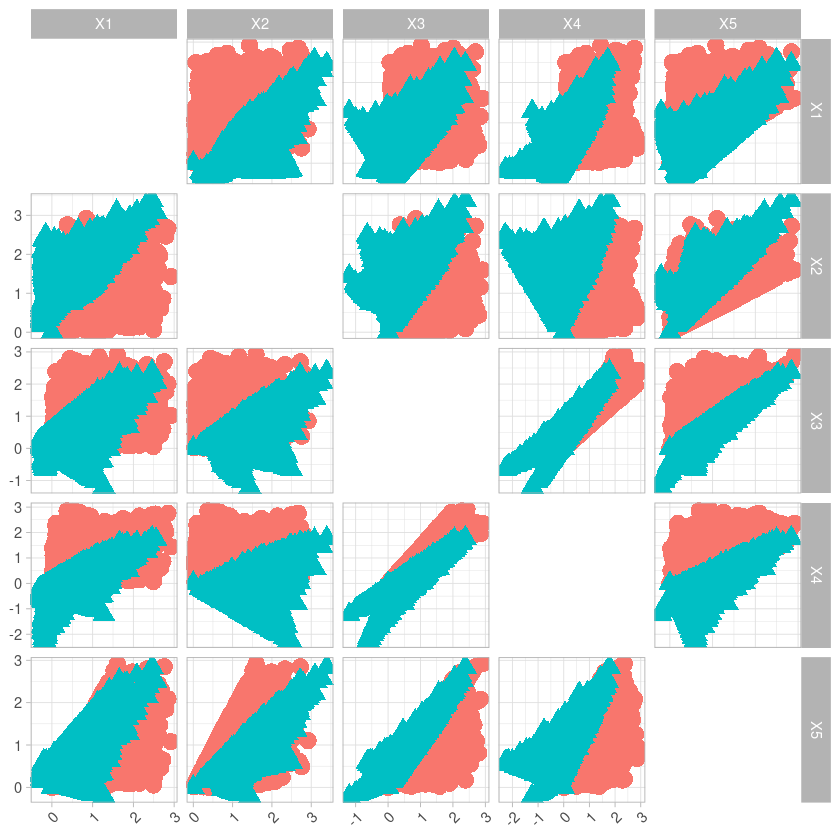

In [50]:
plot_dat2 <- data.frame(X2trafo_2frech)
tmp <- data.frame(rec2_cy)
plot_dat2 <- full_join(plot_dat2, tmp)
plot_dat2$is_rec <- c(rep("False", 10000), rep("True", 10000))


ggpairs(plot_dat2,
            aes(color = is_rec, shape = is_rec, size = 1),
        columns = 1:5,
        upper = list(continuous = "points", combo = "dot_no_facet"),
        diag = list(continuous = "blankDiag", discrete = "barDiag", na = "naDiag")
) + 
theme_light() +
theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

### Spherical K-means

In [51]:
library(skmeans)

In [52]:
kmeanserrs = data.frame(k = 1:5, errs = NA)
kmeansclusterings = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X1[which(rowSums(X1) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


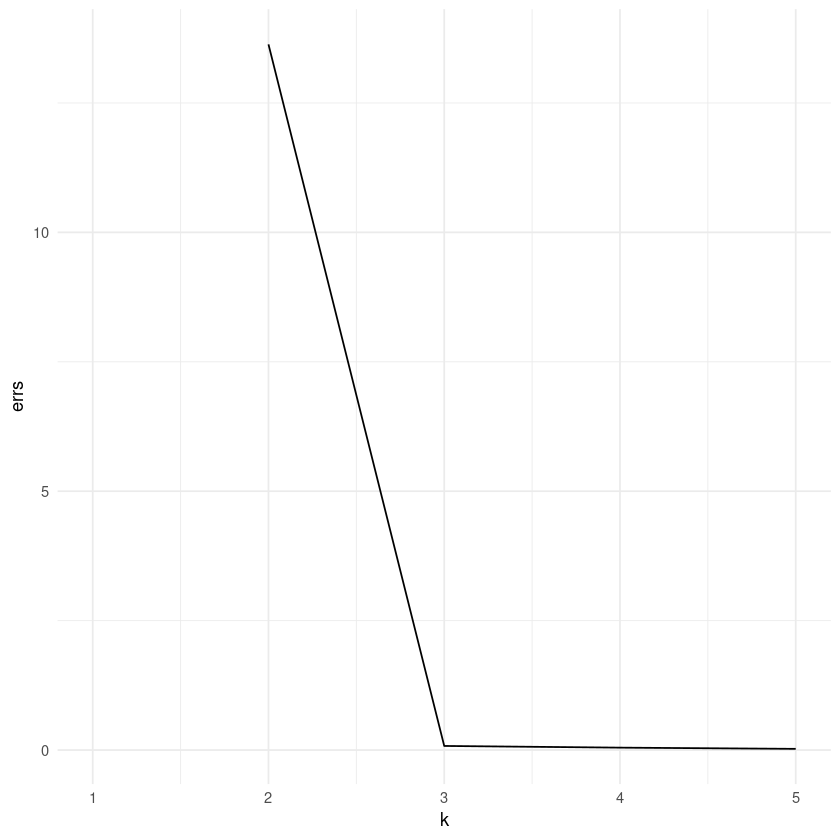

In [53]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()

In [54]:
kmeanserrs = data.frame(k = 1:5, errs = NA)
kmeansclusterings = list()
for(k in 2:5) {
    tmp <- skmeans::skmeans(X2[which(rowSums(X1) > 250), ], k = k)
    kmeansclusterings[[k]] <- tmp
    kmeanserrs[k,2] <- tmp$value
}

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


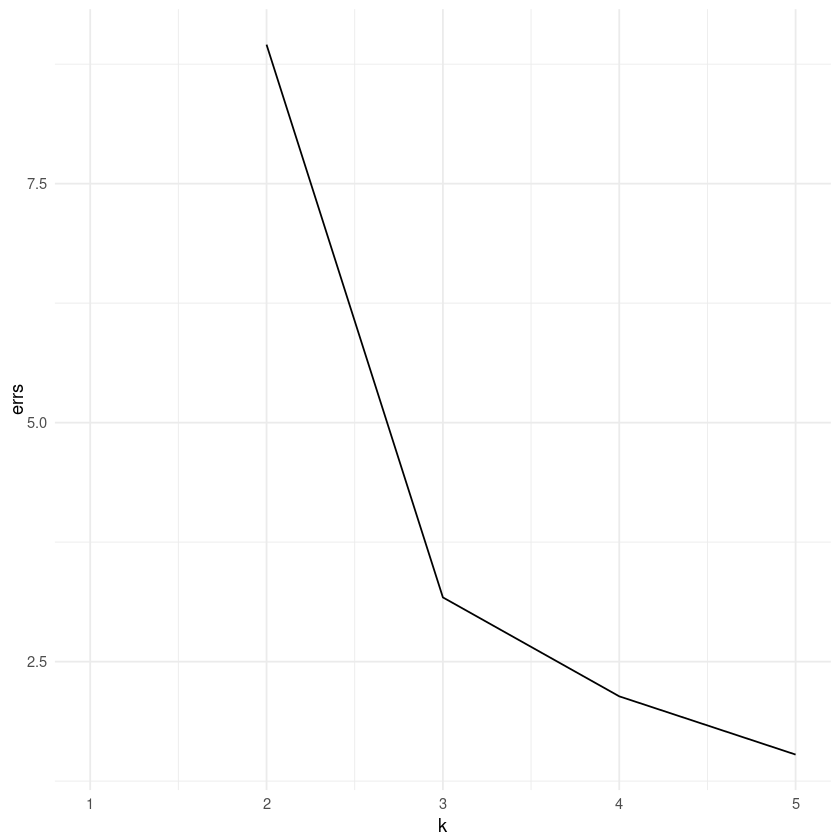

In [55]:
ggplot(aes(x = k, y = errs), data = kmeanserrs) + 
geom_line() +
theme_minimal()